In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext nb_black

In [2]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import matplotlib
plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.titlesize'] = 9
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['xtick.minor.size'] = 1.5
plt.rcParams['ytick.minor.size'] = 1.5
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.minor.width'] = 0.4
plt.rcParams['figure.dpi'] = 225
plt.rcParams['figure.figsize'] = [7.5/2.54, 5/2.54]
plt.rcParams['path.simplify'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['legend.frameon'] = False
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.formatter.limits'] = (-3,3)


/home/jwl2182/.conda/envs/a40/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.


In [4]:


import numpy as np
import scipy.spatial
from matplotlib import pyplot as plt
kernel_scale = 0.1

def all_idx(idx, axis):
    grid = np.ogrid[tuple(map(slice, idx.shape))]
    grid.insert(axis, idx)
    return tuple(grid)

def onehot_initialization(p, axis=0):
    argmax = np.argmax(p, axis=axis)
    ncols = p.shape[0]
    out = np.zeros_like(p)
    out[all_idx(argmax, axis=0)] = 1
    return out
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')**0.5
    return np.exp(kernel_scale*sq_norm)


nb_of_samples = 1001  # Number of points in each function
N = 1000  # Number of functions to sample
A = 50 #Number of actions
# Independent variable samples
lim = 500
X = np.expand_dims(np.linspace(-lim, lim, nb_of_samples), 1)
sigma = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=sigma, 
    size=N*A).reshape([A, N, -1])


offset = 0
strength = 15
orig_ys = np.copy(ys)
beta=100
p = np.exp(beta*(orig_ys[:, :N//2, :] - orig_ys[:, N//2:, :]))
go_impulse = np.sum(p, axis=0, keepdims=True)
p_action = go_impulse / (go_impulse + np.median(go_impulse))
p = p / np.sum(p, axis=0, keepdims=True)

actions = onehot_initialization(p)
actions = np.zeros_like(p)
switch_every = 10
decay = 10#int(switch_every * 0.5)
delay = 1
for t in range(delay, nb_of_samples):
    for n in range(N//2):
        if np.random.rand() < p_action[0, n, t-delay]:
            actions[np.random.choice(A, p=p[:, n, t-delay]), n, t] = 1
        if t % switch_every > 0:
            actions[:, n, t] = actions[:, n, t-(t % switch_every)]


for t in range(offset, 101):
    if t == 0:
        ys[:, N//2:, :] += strength*(actions[:, :, :])*np.exp(-1.0*t/decay) / decay
        ys[:, :N//2:, :] += strength*(actions[:, :, :])*np.exp(-1.0*t/decay) / decay
    else:
        ys[:, N//2:, t:] += strength*(actions[:, :, :-t])*np.exp(-1.0*t/decay) / decay
        ys[:, :N//2:, t:] += strength*(actions[:, :, :-t])*np.exp(-1.0*t/decay) / decay
    
scale = 20

/home/jwl2182/.conda/envs/a40/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp
/home/jwl2182/.conda/envs/a40/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/home/jwl2182/.conda/envs/a40/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [5]:
all_d_vals = []
all_i_vals = []

for n in range(N//2):
    dspns = ys[0, n]
    ispns = ys[0, n+N//2]
    
    dspns = (dspns - np.nanmean(dspns)) / np.nanstd(dspns)
    ispns = (ispns - np.nanmean(ispns)) / np.nanstd(ispns)
    
    trial_actions = np.argmax(actions, axis=0)[n]
    is_action = np.sum(actions, axis=0)[n]
    prev_trial_actions = np.concatenate([[np.nan], trial_actions[:-1]], axis=0)
    idxs = np.where(np.logical_and(is_action>0, np.logical_and(trial_actions==0, prev_trial_actions!=0)))[0]
    
    maxval = switch_every-1
    
    idxs = idxs[np.where(np.logical_and(idxs >= 2*maxval+2, idxs<len(trial_actions)-2*maxval-2))[0]]
    

    d_vals = []
    i_vals = []
    for t in np.arange(-maxval, maxval+1):
        d_vals.append(np.nanmean(dspns[idxs+t]))
        i_vals.append(np.nanmean(ispns[idxs+t]))
    
    
    d_vals = np.array(d_vals) - d_vals[0]
    i_vals = np.array(i_vals) - i_vals[0]
    all_d_vals.append(d_vals)
    all_i_vals.append(i_vals)
    
all_d_vals = np.array(all_d_vals)
all_i_vals = np.array(all_i_vals)
    
    

/home/jwl2182/.conda/envs/a40/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/jwl2182/.conda/envs/a40/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


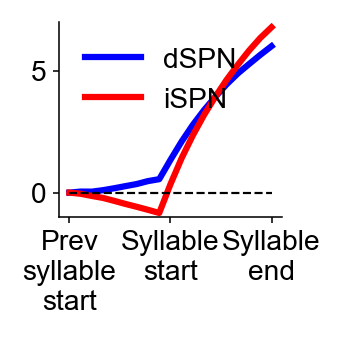

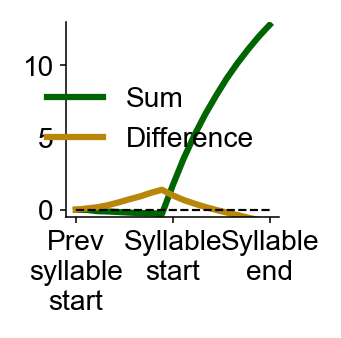

In [6]:
plt.figure(figsize=(4/2.54, 4/2.54))
plt.plot(1.0*np.arange(-maxval, maxval+1)/switch_every, np.nanmean(all_d_vals, axis=0), color="blue", linewidth=2)
plt.plot(1.0*np.arange(-maxval, maxval+1)/switch_every, np.nanmean(all_i_vals, axis=0), color="red", linewidth=2)
plt.plot([-maxval/switch_every, maxval/switch_every], [0, 0], color="black", linestyle="--")
plt.xticks([-maxval/switch_every, 0, maxval/switch_every], ["Prev\nsyllable\nstart", "Syllable\nstart", "Syllable\nend"])
#plt.ylabel("Activity of y_i during syllable i")
plt.legend(["dSPN", "iSPN"])
plt.ylim([-1, 7])
plt.tight_layout()
plt.savefig("Fig4_imaging_simulation_d1d2.pdf")
plt.show()

plt.figure(figsize=(4/2.54, 4/2.54))
plt.plot(1.0*np.arange(-maxval, maxval+1)/switch_every, np.nanmean(all_d_vals+all_i_vals, axis=0), color="darkgreen", linewidth=2)
plt.plot(1.0*np.arange(-maxval, maxval+1)/switch_every, np.nanmean(all_d_vals-all_i_vals, axis=0), color="darkgoldenrod", linewidth=2)
plt.plot([-maxval/switch_every, maxval/switch_every], [0, 0], color="black", linestyle="--")
plt.xticks([-maxval/switch_every, 0, maxval/switch_every], ["Prev\nsyllable\nstart", "Syllable\nstart", "Syllable\nend"])
#plt.ylabel("Activity of y_i during syllable i")
plt.legend(["Sum", "Difference"])
plt.ylim([-0.5, 13])
plt.tight_layout()
plt.savefig("Fig4_imaging_simulation_sumdiff.pdf")
plt.show()



In [7]:
all_d_vals = []
all_i_vals = []

for n in range(N//2):
    dspns = ys[0, n]
    ispns = ys[0, n+N//2]
    
    dspns = (dspns - np.nanmean(dspns)) / np.nanstd(dspns)
    ispns = (ispns - np.nanmean(ispns)) / np.nanstd(ispns)
    
    trial_actions = np.argmax(actions, axis=0)[n]
    prev_trial_actions = np.concatenate([[np.nan], trial_actions[:-1]], axis=0)
    idxs = np.where(np.logical_and(trial_actions==1, prev_trial_actions!=1))[0]
    
    maxval = 10
    
    idxs = idxs[np.where(np.logical_and(idxs >= 2*maxval+2, idxs<len(trial_actions)-2*maxval-2))[0]]
    

    d_vals = []
    i_vals = []
    for t in np.arange(-maxval, maxval+1):
        d_vals.append(np.nanmean(dspns[idxs+t]))
        i_vals.append(np.nanmean(ispns[idxs+t]))
    
    
    d_vals = np.array(d_vals) - d_vals[0]
    i_vals = np.array(i_vals) - i_vals[0]
    all_d_vals.append(d_vals)
    all_i_vals.append(i_vals)
    
all_d_vals = np.array(all_d_vals)
all_i_vals = np.array(all_i_vals)
    
    

/home/jwl2182/.conda/envs/a40/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/jwl2182/.conda/envs/a40/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


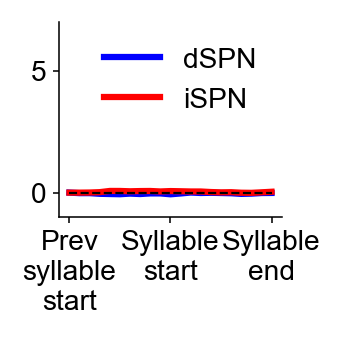

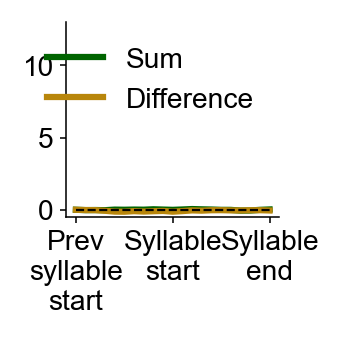

In [8]:
plt.figure(figsize=(4/2.54, 4/2.54))
plt.plot(1.0*np.arange(-maxval, maxval+1)/switch_every, np.nanmean(all_d_vals, axis=0), color="blue", linewidth=2)
plt.plot(1.0*np.arange(-maxval, maxval+1)/switch_every, np.nanmean(all_i_vals, axis=0), color="red", linewidth=2)
plt.plot([-1, 1], [0, 0], color="black", linestyle="--")
plt.xticks([-1, 0, 1], ["Prev\nsyllable\nstart", "Syllable\nstart", "Syllable\nend"])
#plt.ylabel("Activity of y_i during syllable i")
plt.legend(["dSPN", "iSPN"])
plt.ylim([-1, 7])
plt.tight_layout()
plt.savefig("Fig4_shuffle_imaging_simulation_d1d2.pdf")
plt.show()

plt.figure(figsize=(4/2.54, 4/2.54))
plt.plot(1.0*np.arange(-maxval, maxval+1)/switch_every, np.nanmean(all_d_vals+all_i_vals, axis=0), color="darkgreen", linewidth=2)
plt.plot(1.0*np.arange(-maxval, maxval+1)/switch_every, np.nanmean(all_d_vals-all_i_vals, axis=0), color="darkgoldenrod", linewidth=2)
plt.plot([-1, 1], [0, 0], color="black", linestyle="--")
plt.xticks([-1, 0, 1], ["Prev\nsyllable\nstart", "Syllable\nstart", "Syllable\nend"])
#plt.ylabel("Activity of y_i during syllable i")
plt.legend(["Sum", "Difference"])
plt.ylim([-0.5, 13])
plt.tight_layout()
plt.savefig("Fig4_shuffle_imaging_simulation_sumdiff.pdf")
plt.show()



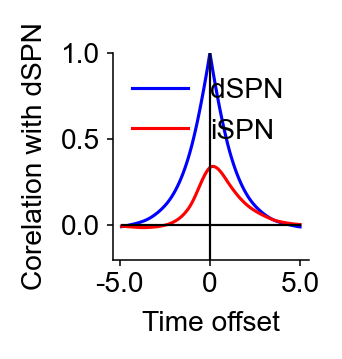

In [10]:


def correlate(x, y, mode="full"):
    return np.correlate((x-np.mean(x))/np.std(x), (y-np.mean(y))/np.std(y), mode=mode) / np.min([len(x), len(y)])

d_act = ys[:, :N//2].mean(0)
i_act = ys[:, N//2:].mean(0)
    
scale = 50
cross_correlations = np.mean([correlate(i_act[i], d_act[i], mode="full")[len(d_act[0])-scale:len(d_act[0])+scale] for i in range(N//2)], axis=0)
cross_correlations_err = np.std([correlate(i_act[i], d_act[i], mode="full")[len(d_act[0])-scale:len(d_act[0])+scale] for i in range(N//2)], axis=0)

auto_correlations = np.mean([correlate(d_act[i], d_act[i], mode="full")[len(d_act[0])-scale:len(d_act[0])+scale] for i in range(N//2)], axis=0)
auto_correlations_err = np.std([correlate(d_act[i], d_act[i], mode="full")[len(d_act[0])-scale:len(d_act[0])+scale] for i in range(N//2)], axis=0)



plt.figure(figsize=(4/2.54, 4/2.54))
plt.plot(np.arange(-len(ys[0])+1, len(ys[0]))[len(ys[0])-scale:len(ys[0])+scale], 
         auto_correlations, color="blue", linewidth=1)
plt.plot(np.arange(-len(ys[0])+1, len(ys[0]))[len(ys[0])-scale:len(ys[0])+scale], 
         cross_correlations, color="red", linewidth=1)
unit = 2*kernel_scale*lim/(nb_of_samples-1)
plt.xticks([-scale, 0, scale], [-scale*unit, 0, scale*unit])
plt.xlabel("Time offset")
plt.ylabel("Corelation with dSPN")
plt.ylim([-0.2, 1])
plt.plot([0, 0], [-1, 1], color="black", linestyle="-")
plt.plot(np.arange(-len(ys[0])+1, len(ys[0]))[len(ys[0])-scale:len(ys[0])+scale],
         0*np.arange(-len(ys[0])+1, len(ys[0]))[len(ys[0])-scale:len(ys[0])+scale], color="black", linestyle="-")
plt.legend(["dSPN", "iSPN"])
plt.tight_layout()
plt.savefig("Fig4_photometry_simulation.pdf")
plt.show()